In [1]:
#pip install jupyter-kite

In [2]:
#conda install -c conda-forge datapackage

In [3]:
#conda install -c conda-forge jsontableschema-panda

In [4]:
#conda install -c conda-forge sparkmagic

In [5]:
from datapackage import Package

In [6]:
import pandas as pd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from tqdm import tqdm

In [9]:
from random import sample

In [10]:
import statsmodels.api as sm

In [11]:
import us
import addfips

In [12]:
pd.DataFrame 

pandas.core.frame.DataFrame

## Get COVID-19 DataPackage and Process Files

In [13]:
package = Package('https://datahub.io/core/covid-19/datapackage.json')

In [14]:
# get list of all resources:
resources = package.descriptor['resources']
resourceList = [resources[x]['name'] for x in range(0, len(resources))]
#print(resourceList)

us_resourceList = [i for i in resourceList if ("us" in i and "csv" in i and "preview" not in i)]


print(us_resourceList)

['us_confirmed_csv', 'us_deaths_csv', 'us_simplified_csv']


In [15]:
# package.descriptor['resources']

In [16]:
us_simplified_csv = package.get_resource('us_simplified_csv').read(keyed=True)

In [17]:
type(us_simplified_csv)

list

In [18]:
df_dict = dict()
def make_pandas_dfs_from_resource(resourcenamelist):
    for resourcename in resourcenamelist:
        try:
            resource = package.get_resource(resourcename).read(keyed=True)
            df_dict[resourcename] = pd.DataFrame(resource)
            print("{name} is complete".format(name=resourcename))
        except:
            print("There was an error for {name}".format(name=resourcename))

In [19]:
make_pandas_dfs_from_resource(us_resourceList)

us_confirmed_csv is complete
us_deaths_csv is complete
us_simplified_csv is complete


In [20]:
df_dict.keys()

dict_keys(['us_confirmed_csv', 'us_deaths_csv', 'us_simplified_csv'])

In [21]:
us_simplified_df = df_dict['us_simplified_csv']

In [22]:
us_deaths_df = df_dict['us_deaths_csv']

In [23]:
us_confirmed_df = df_dict['us_confirmed_csv']

In [24]:
for i in df_dict.values():
    print(i.columns)

Index(['Admin2', 'Date', 'Case', 'Country/Region', 'Province/State'], dtype='object')
Index(['Admin2', 'Date', 'Case', 'Country/Region', 'Province/State'], dtype='object')
Index(['Date', 'Admin2', 'Province/State', 'Confirmed', 'Deaths',
       'Country/Region'],
      dtype='object')


## Shape File with Current Totals of Cases and Deaths

In [25]:
us_simplified_df

,Date,Admin2,Province/State,Confirmed,Deaths,Country/Region
0,2020-01-22,Autauga,Alabama,0,0,US
1,2020-01-23,Autauga,Alabama,0,0,US
2,2020-01-24,Autauga,Alabama,0,0,US
3,2020-01-25,Autauga,Alabama,0,0,US
4,2020-01-26,Autauga,Alabama,0,0,US
...,...,...,...,...,...,...
981955,2020-11-06,Weston,Wyoming,294,1,US
981956,2020-11-07,Weston,Wyoming,296,1,US
981957,2020-11-08,Weston,Wyoming,306,0,US
981958,2020-11-09,Weston,Wyoming,310,0,US


In [26]:
us_simplified_df['Province/State'] 

0         Alabama
1         Alabama
2         Alabama
3         Alabama
4         Alabama
           ...   
981955    Wyoming
981956    Wyoming
981957    Wyoming
981958    Wyoming
981959    Wyoming
Name: Province/State, Length: 981960, dtype: object

In [27]:
us_simplified_df.rename(columns={'Province/State': 'State'}, inplace=True)

In [28]:
us_simplified_df = us_simplified_df[us_simplified_df.Admin2 != 'Unassigned']

In [29]:
us_simplified_df.Date = us_simplified_df.Date.astype("datetime64")

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [30]:
us_simplified_df['Deaths_Previous'] = us_simplified_df.groupby(['Admin2','State'])['Deaths'].shift(1)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
us_simplified_df['Confirmed_Previous'] = us_simplified_df.groupby(['Admin2','State'])['Confirmed'].shift(1)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
us_simplified_df['Deaths_New'] = us_simplified_df.Deaths - us_simplified_df.Deaths_Previous

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
us_simplified_df['Deaths_New_+7'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-7)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
us_simplified_df['Deaths_New_+14'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-14)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
us_simplified_df['Deaths_New_+21'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-21)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
us_simplified_df['Deaths_New_+28'] = us_simplified_df.groupby(['Admin2','State'])['Deaths_New'].shift(-28)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
us_simplified_df['Confirmed_New'] =  us_simplified_df.Confirmed - us_simplified_df.Confirmed_Previous

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
# Add locationcol key 
us_simplified_df['locationcol'] = us_simplified_df['Admin2']+'|'+us_simplified_df['State']

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


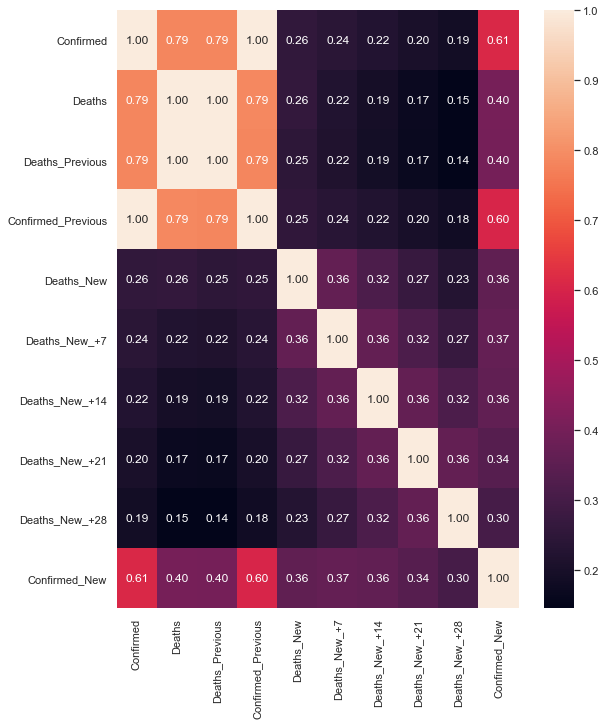

In [39]:
#Corrplot for all of the variables
sns.set(rc={'figure.figsize':(9,11)})
corr = us_simplified_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [52]:
# Sample half of the locations
list_all_locations = list(us_simplified_df['locationcol'].unique())
# sample_num = int(round(len(list_all_locations)/2, 0))
# list_locations_sampled = list_all_locations  #sample(list_all_locations, sample_num) list_all_locations

In [53]:
us_simplified_df.columns

Index(['Date', 'Admin2', 'State', 'Confirmed', 'Deaths', 'Country/Region',
       'Deaths_Previous', 'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7',
       'Deaths_New_+14', 'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'locationcol'],
      dtype='object')

## Outlier Detection

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [55]:
outlier_detect_df = us_simplified_df.dropna()
outlier_detect_df = outlier_detect_df.sample(frac=.1)

In [56]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

X = outlier_detect_df['Confirmed_New'].values.reshape(-1, 1) 
Y = outlier_detect_df['Deaths_New'].values.reshape(-1, 1) 

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination="auto")
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X,Y)
#n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [57]:
outlier_detect_df['score'] = X_scores

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

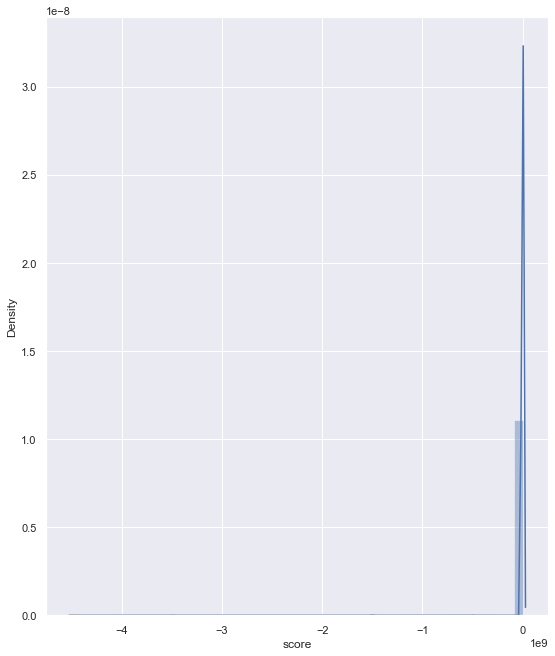

In [58]:
sns.distplot(outlier_detect_df.score)

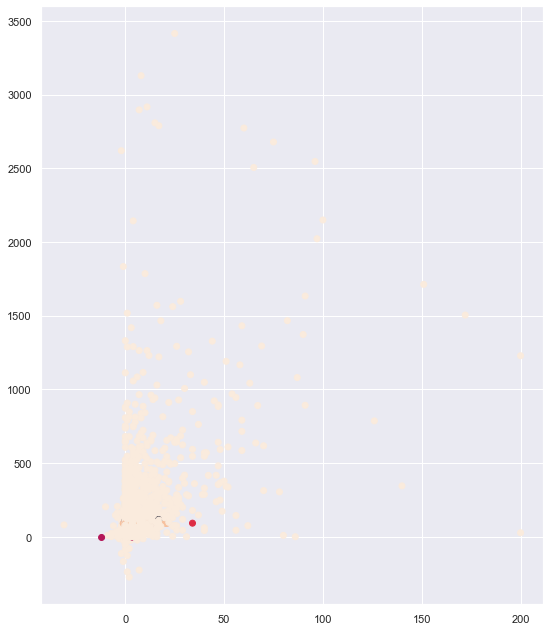

In [59]:
plt.scatter(x="Deaths_New", y="Confirmed_New", c="score", data=outlier_detect_df[outlier_detect_df.score < -.2])
#plt.legend("score")

In [60]:
#clf.fit_predict(us_simplified_df['Confirmed_New'].dropna().values.reshape(-1, 1))

In [61]:
def fit_predict(x):
    x = x.values.reshape(-1, 1)
    score = clf.fit_predict(x)
    return score

In [62]:
#us_simplified_df['score'] = clf.fit_predict(us_simplified_df['Confirmed_New'].values.reshape(-1, 1))

## Add the Rolling Averages and Recombine

In [63]:
list_frames = []
for i in tqdm(list_all_locations):
    frame = us_simplified_df[us_simplified_df.locationcol == i]
    frame['Confirmed_New_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Confirmed_New'].mean()
    frame['Deaths_New_+7_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+7'].mean()
    frame['Deaths_New_+14_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+14'].mean()
    frame['Deaths_New_+21_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+21'].mean()
    frame['Deaths_New_+28_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="Date")['Deaths_New_+28'].mean()
    list_frames.append(frame)

  0%|          | 0/3283 [00:00<?, ?it/s]/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [64]:
large_frame_df = pd.concat(list_frames)

In [65]:
dictmax = {i['locationcol'].max() : i['Deaths_New'].max() for i in list_frames}
dictmax

{'Autauga|Alabama': 2.0,
 'Baldwin|Alabama': 8.0,
 'Barbour|Alabama': 2.0,
 'Bibb|Alabama': 3.0,
 'Blount|Alabama': 7.0,
 'Bullock|Alabama': 2.0,
 'Butler|Alabama': 3.0,
 'Calhoun|Alabama': 8.0,
 'Chambers|Alabama': 3.0,
 'Cherokee|Alabama': 4.0,
 'Chilton|Alabama': 6.0,
 'Choctaw|Alabama': 3.0,
 'Clarke|Alabama': 2.0,
 'Clay|Alabama': 2.0,
 'Cleburne|Alabama': 1.0,
 'Coffee|Alabama': 2.0,
 'Colbert|Alabama': 3.0,
 'Conecuh|Alabama': 2.0,
 'Coosa|Alabama': 1.0,
 'Covington|Alabama': 3.0,
 'Crenshaw|Alabama': 6.0,
 'Cullman|Alabama': 2.0,
 'Dale|Alabama': 8.0,
 'Dallas|Alabama': 3.0,
 'DeKalb|Alabama': 2.0,
 'Elmore|Alabama': 6.0,
 'Escambia|Alabama': 4.0,
 'Etowah|Alabama': 5.0,
 'Fayette|Alabama': 2.0,
 'Franklin|Alabama': 2.0,
 'Geneva|Alabama': 1.0,
 'Greene|Alabama': 2.0,
 'Hale|Alabama': 3.0,
 'Henry|Alabama': 1.0,
 'Houston|Alabama': 6.0,
 'Jackson|Alabama': 2.0,
 'Jefferson|Alabama': 15.0,
 'Lamar|Alabama': 2.0,
 'Lauderdale|Alabama': 3.0,
 'Lawrence|Alabama': 8.0,
 'Lee|Alabama

In [66]:
yuma = large_frame_df[large_frame_df['locationcol'] == 'Cobb|Georgia']

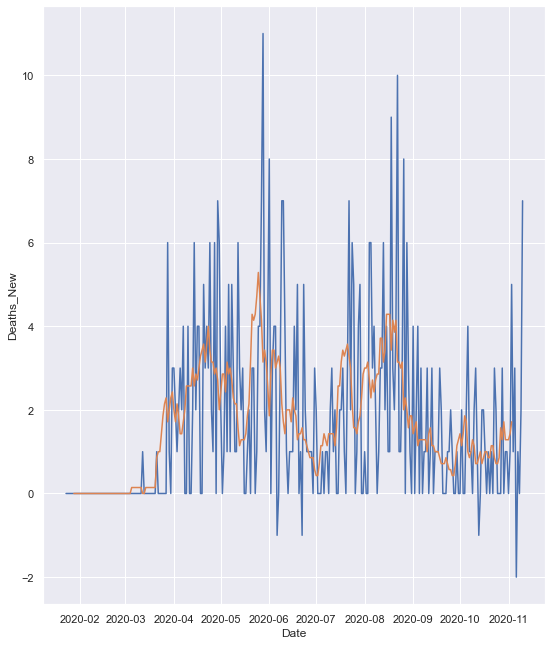

In [67]:
plot1 = sns.lineplot(x="Date", y="Deaths_New", data=yuma)
plt1 = sns.lineplot(x="Date", y="Deaths_New_+7_RollingAvg", data=yuma)

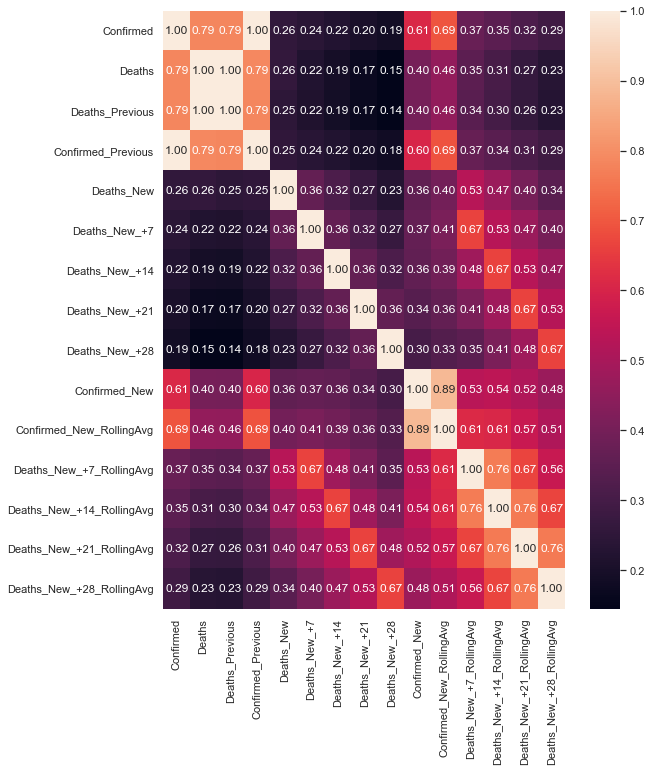

In [68]:
#Corrplot
sns.set(rc={'figure.figsize':(9,11)})
corr = large_frame_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression

## Mapping FIPS Codes

In [70]:
large_frame_df.columns

Index(['Date', 'Admin2', 'State', 'Confirmed', 'Deaths', 'Country/Region',
       'Deaths_Previous', 'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7',
       'Deaths_New_+14', 'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'locationcol', 'Confirmed_New_RollingAvg', 'Deaths_New_+7_RollingAvg',
       'Deaths_New_+14_RollingAvg', 'Deaths_New_+21_RollingAvg',
       'Deaths_New_+28_RollingAvg'],
      dtype='object')

In [71]:
def lookup_location(locationstring):
    af = addfips.AddFIPS()
    try:
        namelist = locationstring.split('|')
        statename = namelist[1]
        countyname = namelist[0]
        fipscode = af.get_county_fips(countyname, state=statename)
        return fipscode
    except:
        return '00000'

In [72]:
tqdm.pandas()

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [73]:
unique_counties = pd.DataFrame(large_frame_df.locationcol.unique(), columns = ['locationcol'])

In [74]:
unique_counties['County_FIPS'] = unique_counties['locationcol'].progress_apply(lookup_location)

100%|██████████| 3282/3282 [01:05<00:00, 49.83it/s]


## Visualizing County-Level Data for COVID

In [75]:
large_frame_df = large_frame_df.merge(unique_counties, on="locationcol", how="left")

In [76]:
large_frame_df_mapping_counties = large_frame_df.groupby(['County_FIPS','State'])['Deaths'].max().reset_index()

In [77]:
large_frame_df_mapping_counties

,County_FIPS,State,Deaths
0,01001,Alabama,31
1,01003,Alabama,84
2,01005,Alabama,9
3,01007,Alabama,17
4,01009,Alabama,26
...,...,...,...
3207,72145,Puerto Rico,0
3208,72147,Puerto Rico,0
3209,72149,Puerto Rico,0
3210,72151,Puerto Rico,0


In [78]:
# conda install -c plotly plotly-geo

In [79]:
#conda update --all

In [80]:
#conda install pandas fiona shapely pyproj rtree

In [81]:
#pip install geopandas==0.3.0

In [82]:
#conda install pyshp

In [83]:
#conda install geopandas

In [84]:
#conda install shapely

In [85]:
#conda install pyshp

# https://plotly.com/python/county-choropleth/
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

df_sample_r = large_frame_df_mapping_counties[large_frame_df_mapping_counties['State'] == 'California']

values = df_sample_r['Deaths'].tolist()
fips = df_sample_r['County_FIPS'].tolist()

colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Population by County', title='California and Nearby States'
)
fig.layout.template = None
fig.show()

In [86]:
sampled_df = large_frame_df

## Ratio of Deaths / Cases and High Death Outliers

In [87]:
sampled_df['ratio'] = sampled_df['Deaths_New_+7_RollingAvg'].astype("float")/sampled_df['Confirmed_New_RollingAvg'].astype("float")

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ratio', ylabel='Density'>

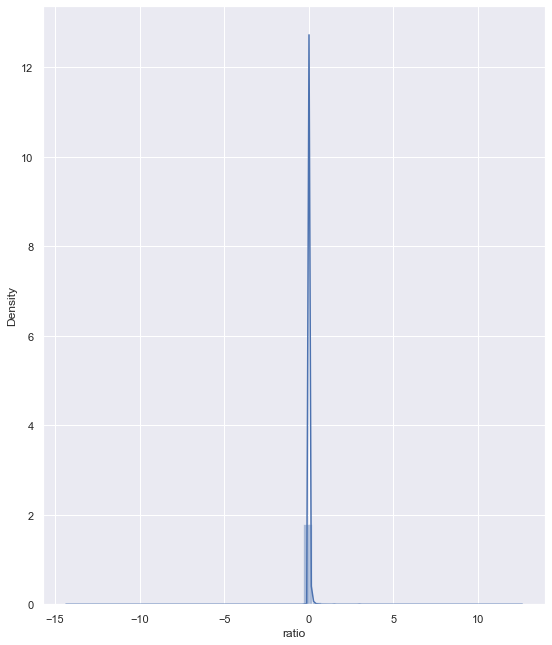

In [88]:
sampled_df2 = sampled_df
sampled_df2.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
sampled_df2.dropna(inplace=True) 
  
# Printing df 
sns.distplot(sampled_df2['ratio'])


In [89]:
high_outliers = sampled_df2[sampled_df2.ratio > (sampled_df2['ratio'].mean() * 75)]
high_outliers.groupby('locationcol').mean()

,Confirmed,Deaths,Deaths_Previous,Confirmed_Previous,Deaths_New,Deaths_New_+7,Deaths_New_+14,Deaths_New_+21,Deaths_New_+28,Confirmed_New,Confirmed_New_RollingAvg,Deaths_New_+7_RollingAvg,Deaths_New_+14_RollingAvg,Deaths_New_+21_RollingAvg,Deaths_New_+28_RollingAvg,ratio
locationcol,,,,,,,,,,,,,,,,
Bee|Texas,1807.000000,30.333333,29.333333,1810.666667,1.000000,0.666667,0.000000,0.333333,0.000000,-3.666667,0.142857,0.476190,0.095238,0.285714,0.238095,3.333333
Bienville|Louisiana,78.000000,16.000000,15.000000,78.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.142857,0.571429,0.142857,0.285714,0.000000,4.000000
Botetourt|Virginia,24.000000,0.000000,0.000000,23.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.142857,0.428571,0.000000,0.000000,0.000000,3.000000
Bowie|Texas,80.000000,2.000000,2.000000,76.000000,0.000000,2.000000,0.000000,0.000000,1.000000,4.000000,0.142857,0.428571,0.857143,-0.714286,0.142857,3.000000
Bronx|New York,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,12.000000,75.000000,112.000000,1.000000,0.142857,0.571429,7.857143,44.142857,106.428571,4.000000
Broome|New York,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.142857,0.428571,0.142857,0.285714,0.428571,3.000000
Butler|Kentucky,218.000000,6.000000,6.000000,218.333333,0.000000,0.000000,0.000000,0.000000,0.333333,-0.333333,0.142857,1.000000,0.000000,0.000000,0.095238,7.000000
Carteret|North Carolina,35.000000,3.000000,3.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.857143,0.000000,-0.857143,0.000000,6.000000
Clark|Washington,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.500000,1.000000,0.500000,0.000000,0.142857,0.428571,0.214286,0.357143,0.928571,3.000000


In [90]:
#sampled_df2[sampled_df2.locationcol == "Juniata|Pennsylvania"].head(48)

In [91]:
#sns.distplot(sampled_df['ratio'].dropna())

In [92]:
sampled_df['Confirmed_New_RollingAvg'].describe()

count    547500.000000
mean         13.892487
std          66.705481
min        -146.000000
25%           0.571429
50%           2.142857
75%           7.857143
max        3283.571429
Name: Confirmed_New_RollingAvg, dtype: float64

In [93]:
sampled_df['Deaths_New_+21_RollingAvg'].describe()

count    547500.000000
mean          0.410432
std           2.900263
min          -3.000000
25%           0.000000
50%           0.000000
75%           0.142857
max         244.571429
Name: Deaths_New_+21_RollingAvg, dtype: float64

In [94]:
# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

X =  sampled_df['Confirmed_New_RollingAvg'].values.reshape(-1, 1) 
Y = sampled_df['Deaths_New_+7_RollingAvg'].values.reshape(-1, 1) 

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

linear_regressor.score(X, Y)

0.3905436362188839

In [95]:
print(linear_regressor.score)

<bound method RegressorMixin.score of LinearRegression()>


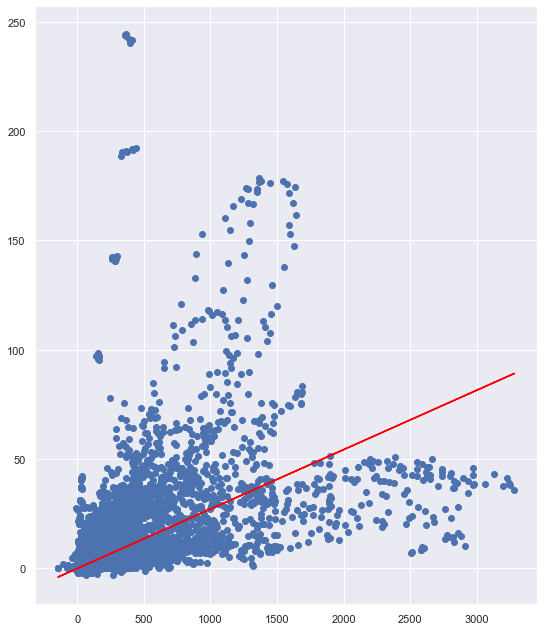

In [96]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [97]:
mod = sm.OLS(Y, X)
res = mod.fit()
print(res.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.402
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                          3.675e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        16:11:00   Log-Likelihood:                     -1.2240e+06
No. Observations:              547500   AIC:                                  2.448e+06
Df Residuals:                  547499   BIC:                                  2.448e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [98]:
#print(sm.stats.linear_rainbow.__doc__)

In [99]:
sm.stats.linear_rainbow(res)

(0.7614181284784188, 0.9999999999999999)

In [100]:
large_frame_df.columns

Index(['Date', 'Admin2', 'State', 'Confirmed', 'Deaths', 'Country/Region',
       'Deaths_Previous', 'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7',
       'Deaths_New_+14', 'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'locationcol', 'Confirmed_New_RollingAvg', 'Deaths_New_+7_RollingAvg',
       'Deaths_New_+14_RollingAvg', 'Deaths_New_+21_RollingAvg',
       'Deaths_New_+28_RollingAvg', 'County_FIPS', 'ratio'],
      dtype='object')

In [101]:
large_frame_df.reset_index(inplace=True)

## Roll Up to State Level

In [102]:
us_simplified_df = us_simplified_df.groupby(['State','Date']).sum().reset_index()

In [103]:
list_frames = []
for i in tqdm(list(us_simplified_df.State.unique())):
    frame = us_simplified_df[us_simplified_df.State == i]
    frame['Confirmed_New_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Confirmed_New'].mean()
    frame['Deaths_New_+7_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+7'].mean()
    frame['Deaths_New_+14_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+14'].mean()
    frame['Deaths_New_+21_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+21'].mean()
    frame['Deaths_New_+28_RollingAvg'] = frame.rolling(7, min_periods=7, center=True, on="Date")['Deaths_New_+28'].mean()
    list_frames.append(frame)

  0%|          | 0/58 [00:00<?, ?it/s]/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [104]:
statelevel_large_df = pd.concat(list_frames)

In [105]:
statelevel_large_df
statelevel_large_df['death+7_to_confirmed_ratio'] = statelevel_large_df['Deaths_New_+7_RollingAvg'].astype("float")/statelevel_large_df['Confirmed_New_RollingAvg'].astype("float")

In [106]:
statelevel_large_df = statelevel_large_df[statelevel_large_df.Confirmed_New_RollingAvg.isna() == False]
statelevel_large_df = statelevel_large_df[statelevel_large_df['Deaths_New_+7_RollingAvg'].isna() == False]

X =  statelevel_large_df['Confirmed_New_RollingAvg'].values.reshape(-1, 1) 
Y = statelevel_large_df['Deaths_New_+14_RollingAvg'].values.reshape(-1, 1) 

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

linear_regressor.score(X, Y)

0.36394564177393884

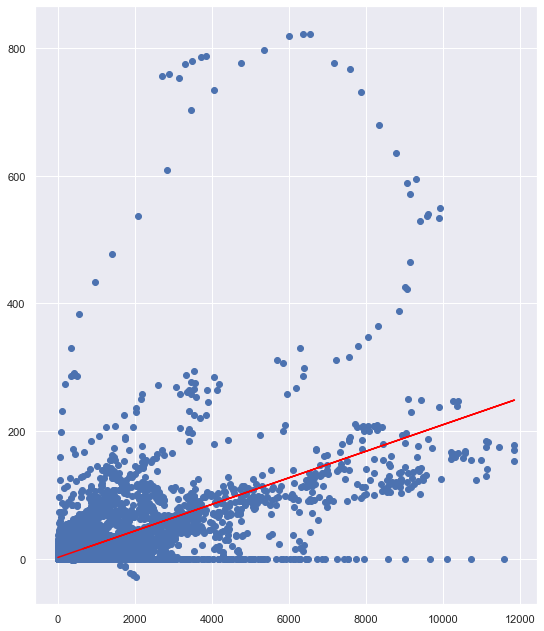

In [107]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [108]:
mod = sm.OLS(Y, X)
res = mod.fit()

In [109]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.430
Model:                            OLS   Adj. R-squared (uncentered):              0.430
Method:                 Least Squares   F-statistic:                          1.261e+04
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        16:11:01   Log-Likelihood:                         -82063.
No. Observations:               16704   AIC:                                  1.641e+05
Df Residuals:                   16703   BIC:                                  1.641e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<AxesSubplot:xlabel='Confirmed_New_RollingAvg', ylabel='Deaths_New_+21_RollingAvg'>

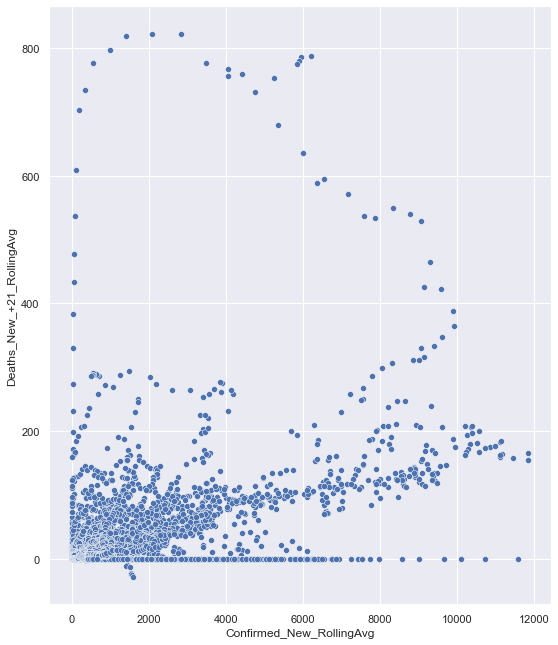

In [110]:
sns.scatterplot(y="Deaths_New_+21_RollingAvg",x="Confirmed_New_RollingAvg",data=statelevel_large_df)

In [111]:
#pip install us


In [112]:
#conda install -c conda-forge addfips

In [113]:
def normalize_name_from_state(x):
    state = us.states.lookup(x)
    normalized_state_name = state.name
    return normalized_state_name

In [114]:
states_regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [115]:
#states_regions

In [116]:
states_regions_merged = statelevel_large_df.merge(states_regions, on="State", how="left")

In [117]:
# some of these don't have regions
states_regions_merged[states_regions_merged.Region.isna() == True]['State'].unique()
states_regions_merged.Region.fillna('Other Region',inplace=True)

In [118]:
states_regions_merged.columns

Index(['State', 'Date', 'Confirmed', 'Deaths', 'Deaths_Previous',
       'Confirmed_Previous', 'Deaths_New', 'Deaths_New_+7', 'Deaths_New_+14',
       'Deaths_New_+21', 'Deaths_New_+28', 'Confirmed_New',
       'Confirmed_New_RollingAvg', 'Deaths_New_+7_RollingAvg',
       'Deaths_New_+14_RollingAvg', 'Deaths_New_+21_RollingAvg',
       'Deaths_New_+28_RollingAvg', 'death+7_to_confirmed_ratio', 'State Code',
       'Region', 'Division'],
      dtype='object')

In [119]:
states_regions_merged_nona = states_regions_merged.dropna()

<AxesSubplot:xlabel='Confirmed_New_RollingAvg', ylabel='Deaths_New_+21_RollingAvg'>

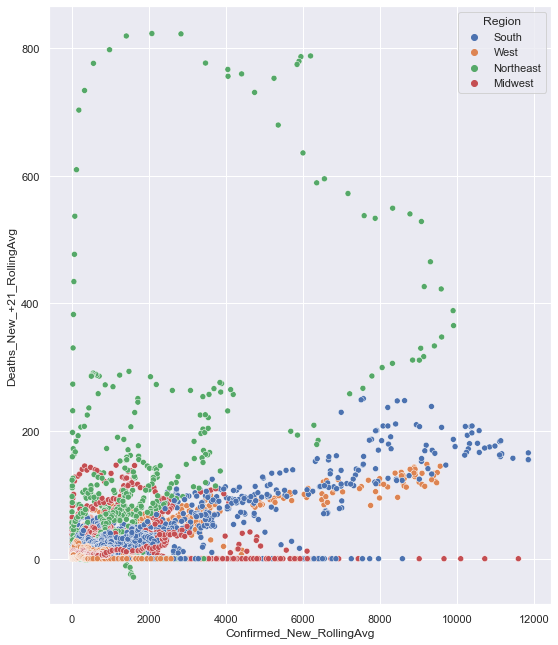

In [120]:
sns.scatterplot(y="Deaths_New_+21_RollingAvg",x="Confirmed_New_RollingAvg", hue="Region", data=states_regions_merged_nona)

In [121]:
states_regions_merged_nona_late = states_regions_merged_nona[states_regions_merged_nona.Date >= '2020-07-01']

<AxesSubplot:xlabel='Confirmed_New_RollingAvg', ylabel='Deaths_New_+7_RollingAvg'>

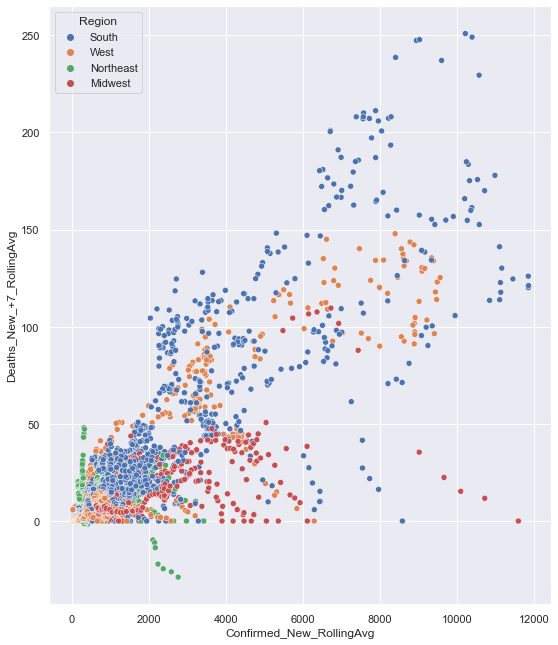

In [122]:
sns.scatterplot(y="Deaths_New_+7_RollingAvg",x="Confirmed_New_RollingAvg", hue="Region", data=states_regions_merged_nona_late)

In [140]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

def regress_two_var(df, X, Y, datecutoff = "2020-01-01"):
    # Cleaning up the dataframe
    df = df[df.date >= datecutoff]
    df = df[df.date <= "2020-10-01"]
    df = df[df['{Y}'.format(Y=Y)].isna() == False]
    df = df[df['{X}'.format(X=X)].isna() == False]
    #dataframe["ratio"] = dataframe['{Y}'.format(Y=Y)]/dataframe['{X}'.format(X=X)]
    Xvar =  df['{X}'.format(X=X)].values.reshape(-1, 1) 
    Xvar1 = sm.add_constant(Xvar) # need to do this for statsmodels for some reason
    Yvar = df['{Y}'.format(Y=Y)].values.reshape(-1, 1) 
    mod = sm.OLS(endog=Yvar,exog=Xvar1)
    res = mod.fit()
    print(res.summary())
    # Graph the regression
    linear_regressor = LinearRegression()  # create object for the class
    fitted_model = linear_regressor.fit(X=Xvar,y=Yvar)  # perform linear regression
    Y_pred = fitted_model.predict(Xvar)  # make predictions
    #return fitted_model
    plt.scatter(y=Yvar, x=Xvar)
    plt.plot(Xvar, Y_pred, color='red')
    plt.title("{X} on {Y} Regression".format(X=X,Y=Y))
    plt.show()
    #Scatterplot to show data
    sns.scatterplot(y='{Y}'.format(Y=Y),x='{X}'.format(X=X), data=df)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          5.607e+04
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        17:55:20   Log-Likelihood:                         -17160.
No. Observations:                4743   AIC:                                  3.432e+04
Df Residuals:                    4742   BIC:                                  3.433e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

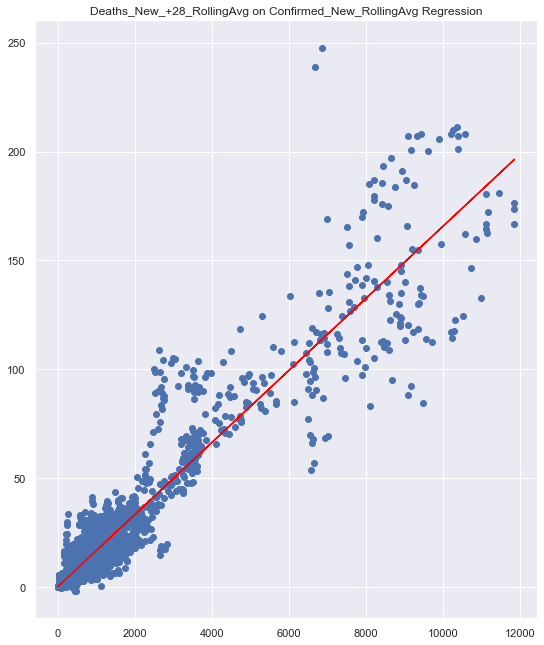

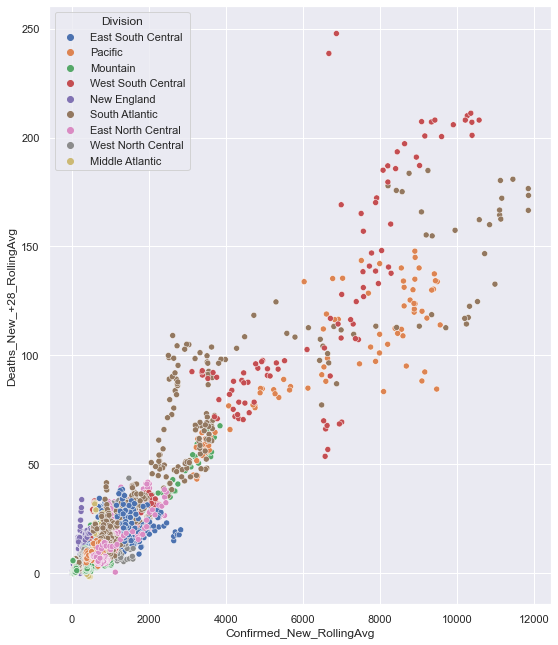

In [133]:
regress_two_var(states_regions_merged_nona_late,"Confirmed_New_RollingAvg","Deaths_New_+28_RollingAvg")

In [134]:
large_frame_df_divisions = large_frame_df.merge(states_regions, on="State", how="left")

In [135]:
#large_frame_df_divisions

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.670
Model:                            OLS   Adj. R-squared (uncentered):              0.670
Method:                 Least Squares   F-statistic:                          3.775e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        17:56:09   Log-Likelihood:                     -2.0919e+05
No. Observations:              185722   AIC:                                  4.184e+05
Df Residuals:                  185721   BIC:                                  4.184e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

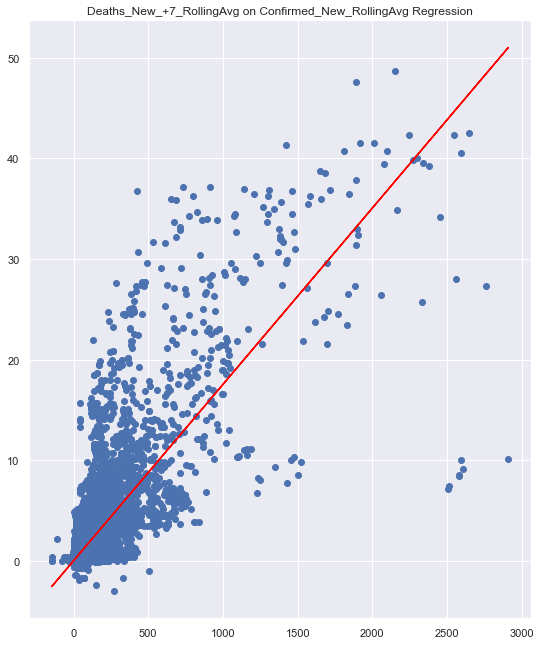

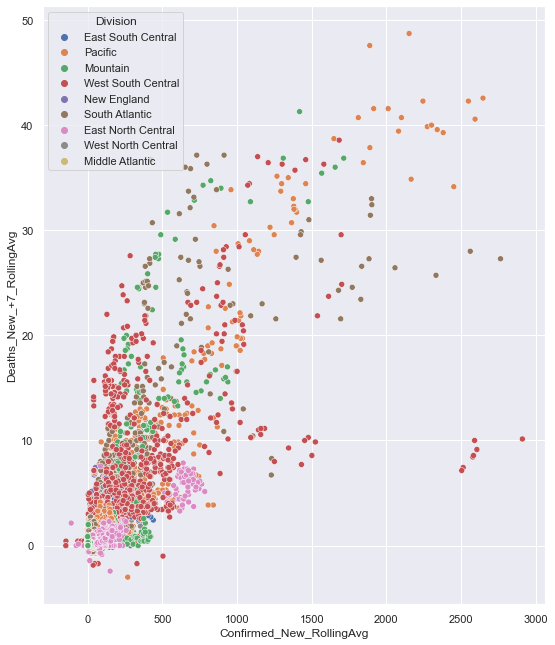

In [139]:
regress_two_var(large_frame_df_divisions,"Confirmed_New_RollingAvg","Deaths_New_+7_RollingAvg","2020-08-01")

In [141]:
import os

## Export Full Dataset to File

In [148]:
os.chdir(r'/Users/philip.ballentine/Documents/Scripts')
path = str(os.getcwd())
filename = "covid_dataset_full.csv"

In [149]:
#large_frame_df_divisions.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

covid_dataset_full.csv has been created in /Users/philip.ballentine/Documents/Scripts


In [150]:
#create sample
large_frame_df_divisions_sample = large_frame_df_divisions.sample(frac=.1)

filename = "covid_dataset_sample.csv"
large_frame_df_divisions_sample.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

covid_dataset_sample.csv has been created in /Users/philip.ballentine/Documents/Scripts
